# Online Payment Fraud Detection Project

In this project we try to detect online payment frauds with Machine Learning models. We will compare and evaluate different models to detect if a transaction is fraudolent or not, by training these models on a dataset containing more than 6 millions data points.
This is a Classification Task in a Supervised Learning environment, the model will need to recognize whether the transaction is fraudolent or not by detecting abnormal activities in the input features.

## Splitting training/test set

We need to split our dataset even before doing any other analysis because otherwise there's a high chance of overfitting, this would happen because the feature engineering would happen on the whole dataset. Another reason is that we would lose the ability of getting an unbiased performance evaluation of our model, this means that when the model would see some new data it's performance would decrease from our test set predictions.

In [1]:
# Let's import the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from cfmatrix import make_confusion_matrix
from imblearn.combine import SMOTETomek
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [2]:
df = pd.read_csv("onlinefraud.csv")

In [3]:
train_set, test_set = train_test_split(df, test_size=0.1)

## Data exploration

In this section we will explore the dataset by analyzing each feature and the relationships with each other

We import our dataset and visualize the first couple of rows

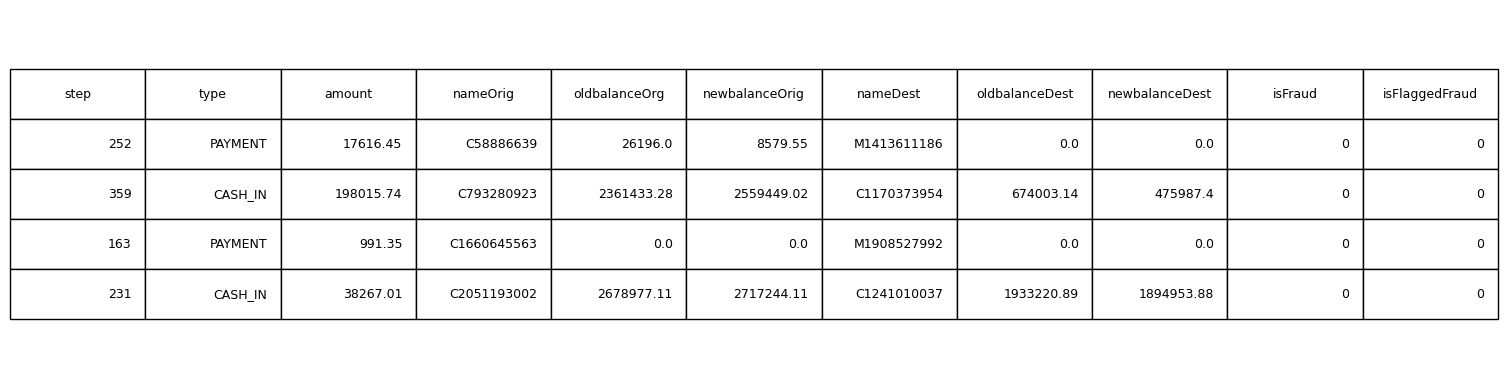

In [4]:
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
# ax.axis('tight')

table = ax.table(cellText=train_set.values[[0, 1, 2, 3]], colLabels=train_set.columns, loc='center')
table.set_fontsize(40)
table.scale(3.0, 3.0)

# fig.tight_layout()
plt.show()

### Exploring features

We can now analyze each feature and detect correlations. The following is the list of columns:
- step: it represents a unit of time where 1 step equals 1 hour
- type: type of online transaction
- amount: the amount of the transaction
- nameOrig: customer starting the transaction
- oldbalanceOrg: balance of customer before the transaction
- newbalanceOrig: balance of customer after the transaction
- nameDest: receiver customer of the transaction
- oldbalanceDest: initial balance of receiver customer before the transaction
- newbalanceDest: the new balance of receiver customer after the transaction
- isFraud: fraud transaction, this is the target label
- isFlaggedFraud: this feature is not described in the dataset description

We can visualize some of the most interesting features

#### Step

It represents a unit of time where 1 step equals 1 hour, in the following graph we can see the time distribution.

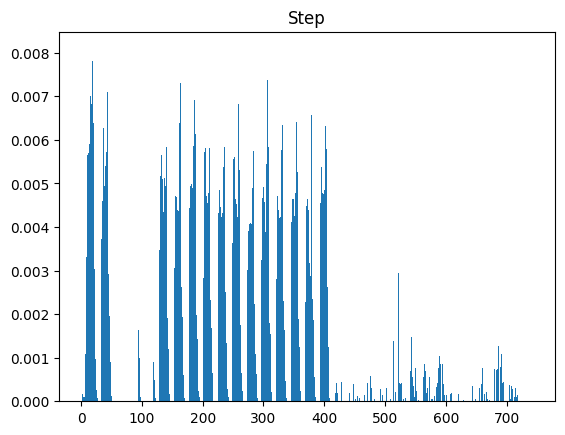

In [5]:
step = train_set["step"]
max_hours = step.max()

plt.title('Step')
plt.hist(step, max_hours, density=True)
plt.show()

#### Type

It represent a type of online transaction, there are 5 classes:
- CASH_OUT
- PAYMENT
- CASH_IN
- TRANSFER
- DEBIT

We can plot its distribution and check which one is the most frequent in our dataset.

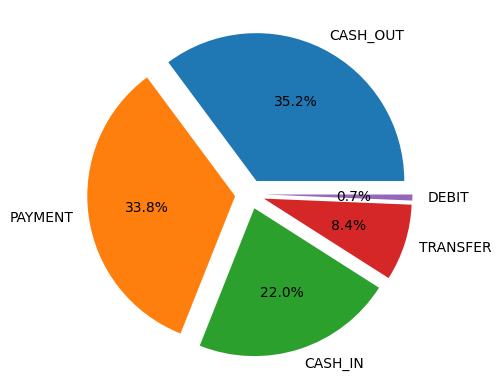

In [6]:
type = train_set["type"].value_counts()
transaction_names = type.index.to_list()
quantity = type.values
expl = np.array([0.1, 0.1, 0.1, 0.1, 0.1])
figure = plt.pie(quantity, labels=transaction_names, explode=expl, autopct='%1.1f%%')
plt.show()

It looks like most of the transactions are either CASH_OUT or PAYMENT, so the majority of frauds will be of one of this two categories.

#### isFraud

We can notice from the graphs below that this feature is imbalanced, which is not ideal for a classification task.

,isFraud
isFraud,
0,5718973
1,7385


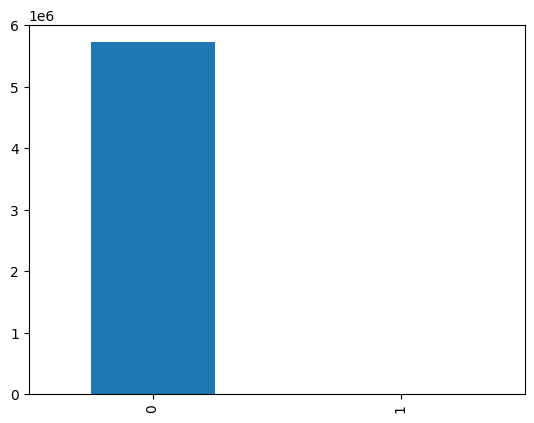

In [7]:
train_set["isFraud"].value_counts().plot(kind='bar')
pd.pivot_table(train_set, index=train_set["isFraud"], values='isFraud', aggfunc='count')

#### Amount

Let's see the 100 largest transaction imports

In [8]:
train_set.nlargest(100, "amount")

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3686583,276,TRANSFER,92445516.64,C1715283297,0.0,0.0,C439737079,9.595980e+03,9.245511e+07,0,0
4060598,300,TRANSFER,73823490.36,C2127282686,0.0,0.0,C753026640,9.362401e+07,1.674475e+08,0,0
4146397,303,TRANSFER,71172480.42,C2044643633,0.0,0.0,C84111522,1.134615e+08,1.846340e+08,0,0
3946920,286,TRANSFER,69886731.30,C1425667947,0.0,0.0,C167875008,1.515387e+08,2.214254e+08,0,0
3911956,284,TRANSFER,69337316.27,C1584456031,0.0,0.0,C1472140329,1.130072e+08,1.823446e+08,0,0
...,...,...,...,...,...,...,...,...,...,...,...
4064987,300,TRANSFER,40686891.57,C1773319125,0.0,0.0,C1246973714,4.620592e+07,8.689281e+07,0,0
3802364,281,TRANSFER,40639589.17,C385252041,0.0,0.0,C744189981,1.011630e+08,1.418026e+08,0,0
3759492,279,TRANSFER,40576871.68,C231288689,0.0,0.0,C2120613885,4.204843e+07,8.262530e+07,0,0
4157030,303,TRANSFER,40492320.04,C1729518588,0.0,0.0,C1065997164,6.917267e+07,1.096650e+08,0,0


But neither of this transactions is a fraud

In [9]:
x = train_set.nlargest(100, "amount").isFraud
counter = 0
if 1 in x.values:
    counter +=1
counter

0

We can conclude that frauds are happening in transactions that have low amount of money

#### oldBalanceOrig

We can plot the 10 largest balances of the dataset and compare them with the newBalanceOrig

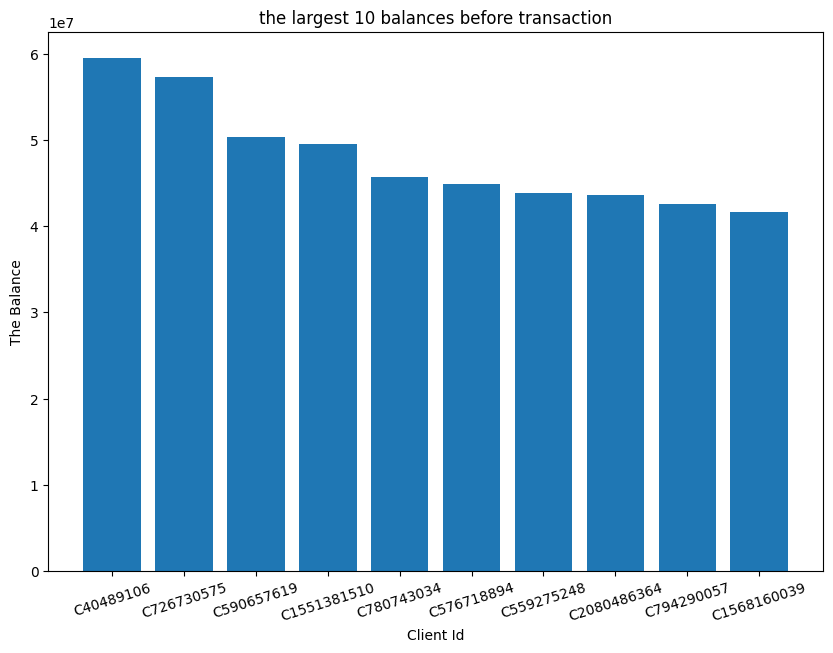

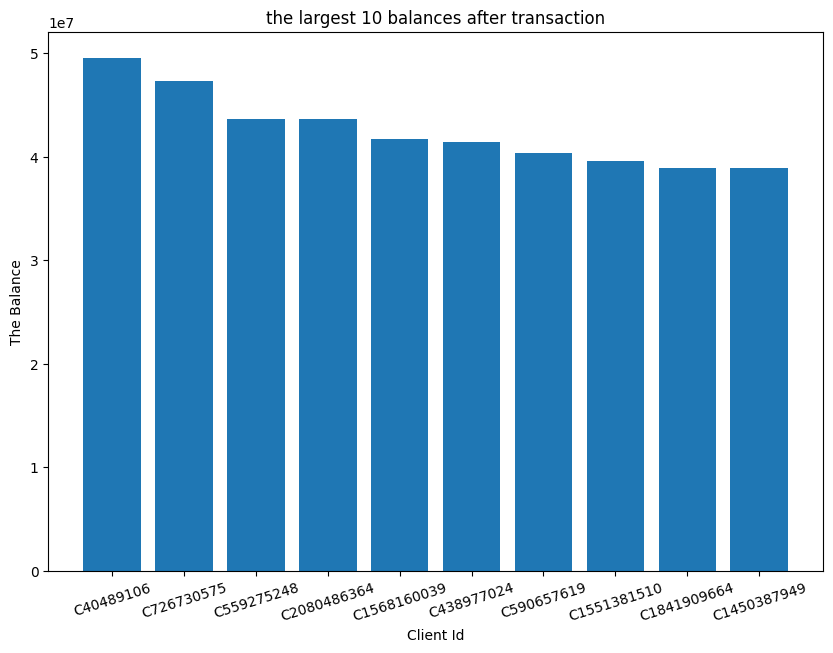

In [10]:
# Before Transaction
plt.figure(figsize = [10,7])
plt.bar(train_set.nlargest(10, 'oldbalanceOrg').nameOrig, train_set.nlargest(10, 'oldbalanceOrg').oldbalanceOrg)
plt.xticks(rotation = 17.5) # to give more spacing for IDs
plt.title('the largest 10 balances before transaction')
plt.xlabel('Client Id')
plt.ylabel('The Balance')
plt.show()

# After Transaction
plt.figure(figsize = [10,7])
plt.bar(train_set.nlargest(10, 'newbalanceOrig').nameOrig, train_set.nlargest(10, 'newbalanceOrig').newbalanceOrig)
plt.xticks(rotation = 17.5) # to give more spacing for IDs
plt.title('the largest 10 balances after transaction')
plt.xlabel('Client Id')
plt.ylabel('The Balance')
plt.show()

The first two clients remain the same.
We can also plot the distribution before and after the transaction.

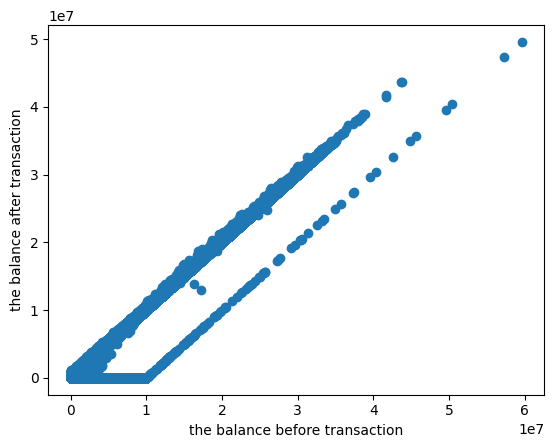

In [11]:
plt.scatter(train_set["oldbalanceOrg"], train_set["newbalanceOrig"])
plt.xlabel('the balance before transaction')
plt.ylabel('the balance after transaction')
plt.show()

### Finding correlations

In [12]:
train_set[['oldbalanceOrg', 'newbalanceOrig']].corr()

,oldbalanceOrg,newbalanceOrig
oldbalanceOrg,1.0000,0.9988
newbalanceOrig,0.9988,1.0000


The sampling distribution shows a strong positive correlation between the balance before and after the transaction.
Now let's have a look at the correlation between features of dataframe compared to the isFraud column.

isFraud           1.000000
amount            0.077149
isFlaggedFraud    0.043512
step              0.031832
oldbalanceOrg     0.010159
newbalanceDest    0.000739
oldbalanceDest   -0.005802
newbalanceOrig   -0.008186
Name: isFraud, dtype: float64


<AxesSubplot: >

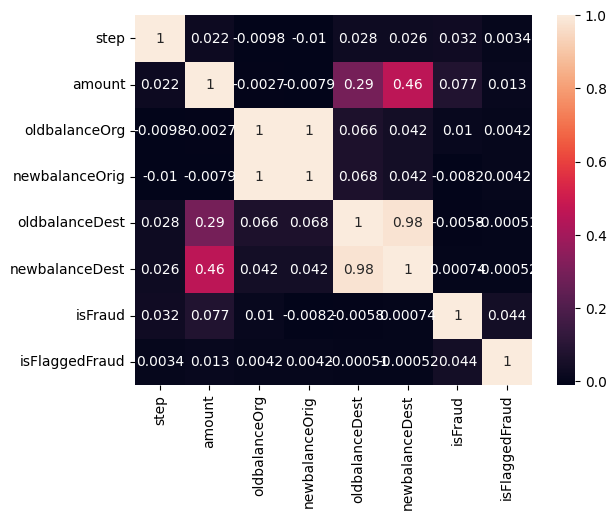

In [13]:
corr_isFraud = train_set.corr(numeric_only=True)
print(corr_isFraud["isFraud"].sort_values(ascending=False))

sb.heatmap(corr_isFraud, annot=True)

As we can see from these results and the observations we made in the previous chapter, it seems that isFraud is not strongly correlated with other columns.

## Preprocessing and Feature Selection

We check if there are any missing features in the dataset

In [14]:
print(train_set.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


As we can see there aren't null values in any feature, so we won't need to do some data cleaning.

We observed at the beginning that for the isFlaggedFraud column there's not much information, it is not clear what is it's purpose. We can see that it is utilized in the dataset only few times, so we drop it from the dataframe.
The correlation map also shows that there's no correlation between frauds and the customers IDs, so we can remove them.
To drop columns we need to create a custom Transformer

In [15]:
train_set["isFlaggedFraud"].value_counts()

0    5726344
1         14
Name: isFlaggedFraud, dtype: int64

### Balance Dataset

In [16]:
class_count_0, class_count_1 = train_set['isFraud'].value_counts()
class_0 = train_set[train_set['isFraud'] == 0]
class_1 = train_set[train_set['isFraud'] == 1]

class_0_under = class_0.sample(class_count_1)
train_set = pd.concat([class_0_under, class_1], axis=0)

In [17]:
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

Next we create a Pipeline of transformations we need to execute on our data, this way we can have a predefined course also for new data before we can fit the model

In [18]:
# This pipeline handles both numerical and categorical data
# But it also returns a numpy array instead of a dataframe, so we need to do some tricks
cat_attribs = ["type"]
num_attribs = ["step", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
drop_attribs = ['isFlaggedFraud', 'nameOrig', 'nameDest']

full_pipeline = ColumnTransformer([
    ("dropCol", "drop", drop_attribs),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_attribs),
    ("num", StandardScaler(), num_attribs)
], verbose_feature_names_out=False, remainder='passthrough')

train_set = pd.DataFrame(full_pipeline.fit_transform(train_set), columns=full_pipeline.get_feature_names_out())
train_set.head()

,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,0.0,0.0,0.0,1.0,0.0,-0.463417,-0.424243,-0.372662,-0.201945,-0.255807,-0.340861,0.0
1,0.0,0.0,0.0,1.0,0.0,0.535205,-0.404316,-0.342563,-0.178008,-0.255807,-0.340861,0.0
2,0.0,1.0,0.0,0.0,0.0,0.252090,-0.359654,-0.382740,-0.208516,-0.125301,-0.189384,0.0
3,0.0,1.0,0.0,0.0,0.0,-1.384827,-0.355308,-0.376240,-0.208516,-0.248859,-0.273901,0.0
4,1.0,0.0,0.0,0.0,0.0,-1.477482,-0.390551,6.932834,9.359916,0.357758,0.169853,0.0


## Models Comparison

Let's train some models and compare them, for this project we will use:
- Logistic Regression
- Random Forest
- MLP Neural Network

We will also use cross validation

### First struggles

As soon as we start training our models for the first time we understand that the models initialization will need some tweaks to decrease the complexity and build time. In our host machine the program was taking up to 3GB of RAM and 10 minutes to build even the simplest Logistic Regressor. So we limit the iterations needed by the model to converge to 300, we start training again and we get the following results

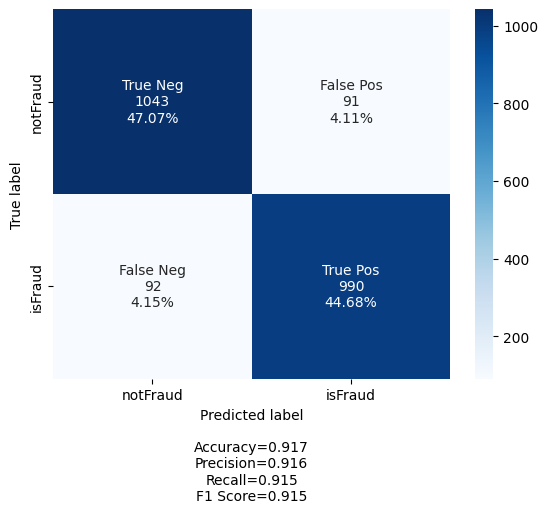

In [19]:
y = train_set.loc[:, "isFraud"]
X = train_set.loc[:, train_set.columns != "isFraud"]
labels = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["notFraud", "isFraud"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)

model = LogisticRegression(max_iter=300)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
cf_matrix = confusion_matrix(y_val, y_pred)
make_confusion_matrix(cf_matrix, group_names=labels, categories=categories)

# print("Accuracy: %3.f" % accuracy_score(y_val, y_pred))


The accuracy is very high, but if we look at the Confusion Matrix we notice that we predict almost all the "notFraud" transaction correctly, but also that we do not classify the fraudulent ones at all! Basically the model learnt to always predict the notFraud class without doing any analysis, because this is the most convenient way to minimize the Loss Function. This can also be noted by looking at the Recall Score, which is very low, meaning that the classifier failed to predict the minority class label. 
We can show this even better by doing the training only on one column

In [20]:
# y = train_set.loc[:, "isFraud"]
# X_reduced = train_set.loc[:, ["amount"]]

# X_train, X_val, y_train, y_val = train_test_split(X_reduced, y, test_size=0.15)

# model = LogisticRegression(max_iter=300)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_val)
# cf_matrix = confusion_matrix(y_val, y_pred)
# make_confusion_matrix(cf_matrix, group_names=labels, categories=categories)

As we can see from the results the accuracy is still very high, and the confusion matrix is almost identical. This is happening because we have a highly imbalanced dataset, meaning that the occurrencies where "isFraud" is 0 are almost 27 times more than where "isFraud" is 1. We try to deal with this imbalance by applying resampling.
We can use the "imblearn" library to apply both undersampling and oversampling, but first we want to visualize this dataset imbalance by plotting it in a 2D space. To do so we need to use a Dimensionality Reduction technique, PCA in this case, because the dataset has many dimensions.

In [21]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

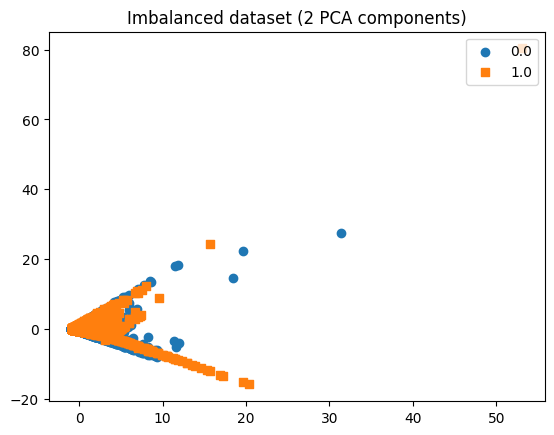

In [22]:
colors = ['#1F77B4', '#FF7F0E']
markers = ['o', 's']
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)
plot_2d_space(X_pca, y, 'Imbalanced dataset (2 PCA components)')

Even if this techniques balance the dataset, they also have their weknesses. For example oversampling will increase the risk of overfitting, and undersampling will increase the risk of information loss.
Executing undersampling combined with oversampling revealed to be more difficult than I initially thought. After 20 minutes of running wthout any result and after tweaking various versions of both sklearn and imblearn without any improvement I decided to just do undersampling with TomekLink.

In [23]:
# y = train_set.loc[:, "isFraud"]
# X = train_set.loc[:, train_set.columns != "isFraud"]
# X = train_set.loc[:, ["amount"]]
kf = KFold(n_splits=10)
# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)

We can visualize the KFold object and see what it looks like

In [38]:
y = train_set.loc[:, "isFraud"]
X = train_set.loc[:, train_set.columns != "isFraud"]

Then we define the list of models we want to evaluate

In [39]:
models = {
    "LR": LogisticRegression(max_iter=300),
    "RF": RandomForestClassifier(max_depth=4, n_estimators=100),
}

In [41]:
final_scores = np.zeros((2, 4)) # each row: accuracy, recall, precision, f1
i = 0 # model index

for name, model in models.items():
    k = 0
    model_scores = np.zeros((10, 4)) # each row: accuracy, recall, precision, f1
    print(f'Training Model {name} \n--------------')
    for train_index, val_index in kf.split(X, y):
        # get the actual arrays
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        # train model and get prediction
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        model_scores[k][0] = accuracy_score(y_val, y_pred)
        model_scores[k][1] = recall_score(y_val, y_pred, average='micro')
        model_scores[k][2] = precision_score(y_val, y_pred, average='micro')
        model_scores[k][3] = f1_score(y_val, y_pred, average='micro')
        k += 1
    
    final_scores[i][0] = model_scores[:, 0].mean()
    final_scores[i][1] = model_scores[:, 1].mean()
    final_scores[i][2] = model_scores[:, 2].mean()
    final_scores[i][3] = model_scores[:, 3].mean()

    print(f"Avarage accuracy:  {final_scores[i][0]}")
    print(f"Avarage recall:  {final_scores[i][1]}")
    print(f"Avarage precision:  {final_scores[i][2]}")
    print(f"Avarage f1:  {final_scores[i][3]}")

Training Model LR 
--------------
Avarage accuracy:  0.9057549085985105
Avarage recall:  0.9057549085985105
Avarage precision:  0.9057549085985105
Avarage f1:  0.9057549085985107
Training Model RF 
--------------
Avarage accuracy:  0.9551794177386596
Avarage recall:  0.9551794177386596
Avarage precision:  0.9551794177386596
Avarage f1:  0.9551794177386596


In [ ]:
# prepare test set
y_test = test_set.loc[:, "isFraud"]
X_test = test_set.loc[:, test_set.columns != "isFraud"]

# train choosen model
final_model = LogisticRegression(max_iter=300)
final_model.fit(X_train.values, y_train.values)

# make predictions for test data
y_final_pred = final_model.predict(X_test.values)

# evaluate predictions
print(f'Accuracy: {accuracy_score(y_test, y_final_pred)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_final_pred)}')

ValueError: could not convert string to float: 'PAYMENT'